In [24]:
import PIL
import time
import copy
import torch
import pathlib
import torchvision
from PIL import Image
from tqdm import tqdm
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torchvision import datasets, models, transforms
from custom_dataset import DIV2K_Dataset, DIV2K_Square_Dataset

In [3]:
DIV2K_path = pathlib.Path('../datasets/DIV2K').absolute()
DIV2K_path

PosixPath('/home/hacker/Documents/Super-Resolution/src/../datasets/DIV2K')

In [4]:
# define paths
DIV2K_train_HR_crop_600 = DIV2K_path/'custom'/'DIV2K_train_HR_crop_600'
DIV2K_train_LR_600_150 = DIV2K_path/'custom'/'DIV2K_train_LR_600_150'
DIV2K_valid_HR_crop_600 = DIV2K_path/'custom'/'DIV2K_valid_HR_crop_600'
DIV2K_valid_LR_600_150 = DIV2K_path/'custom'/'DIV2K_valid_LR_600_150'

In [5]:
train_LR, train_HR = DIV2K_train_LR_600_150, DIV2K_train_HR_crop_600
valid_LR, valid_HR = DIV2K_valid_LR_600_150, DIV2K_valid_HR_crop_600

In [6]:
datasets = {
    'train': DIV2K_Square_Dataset(input_dir=train_LR, target_dir=train_HR, transform=transforms.ToTensor()),
    'val': DIV2K_Square_Dataset(input_dir=valid_LR, target_dir=valid_HR, transform=transforms.ToTensor())
}
dataloaders = {x: torch.utils.data.DataLoader(datasets[x], batch_size=4, shuffle=True, num_workers=4) for x in ['train', 'val']}
dataset_sizes = {x: len(datasets[x]) for x in ['train', 'val']}

In [7]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [12]:
inputs.shape

torch.Size([4, 3, 150, 150])

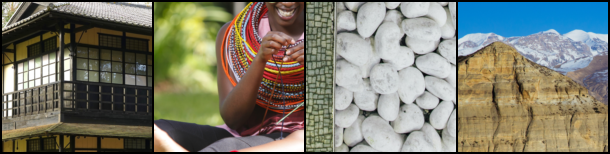

In [9]:
# Low Res
inputs, target = next(iter(dataloaders['train']))
transforms.ToPILImage()(torchvision.utils.make_grid(inputs))

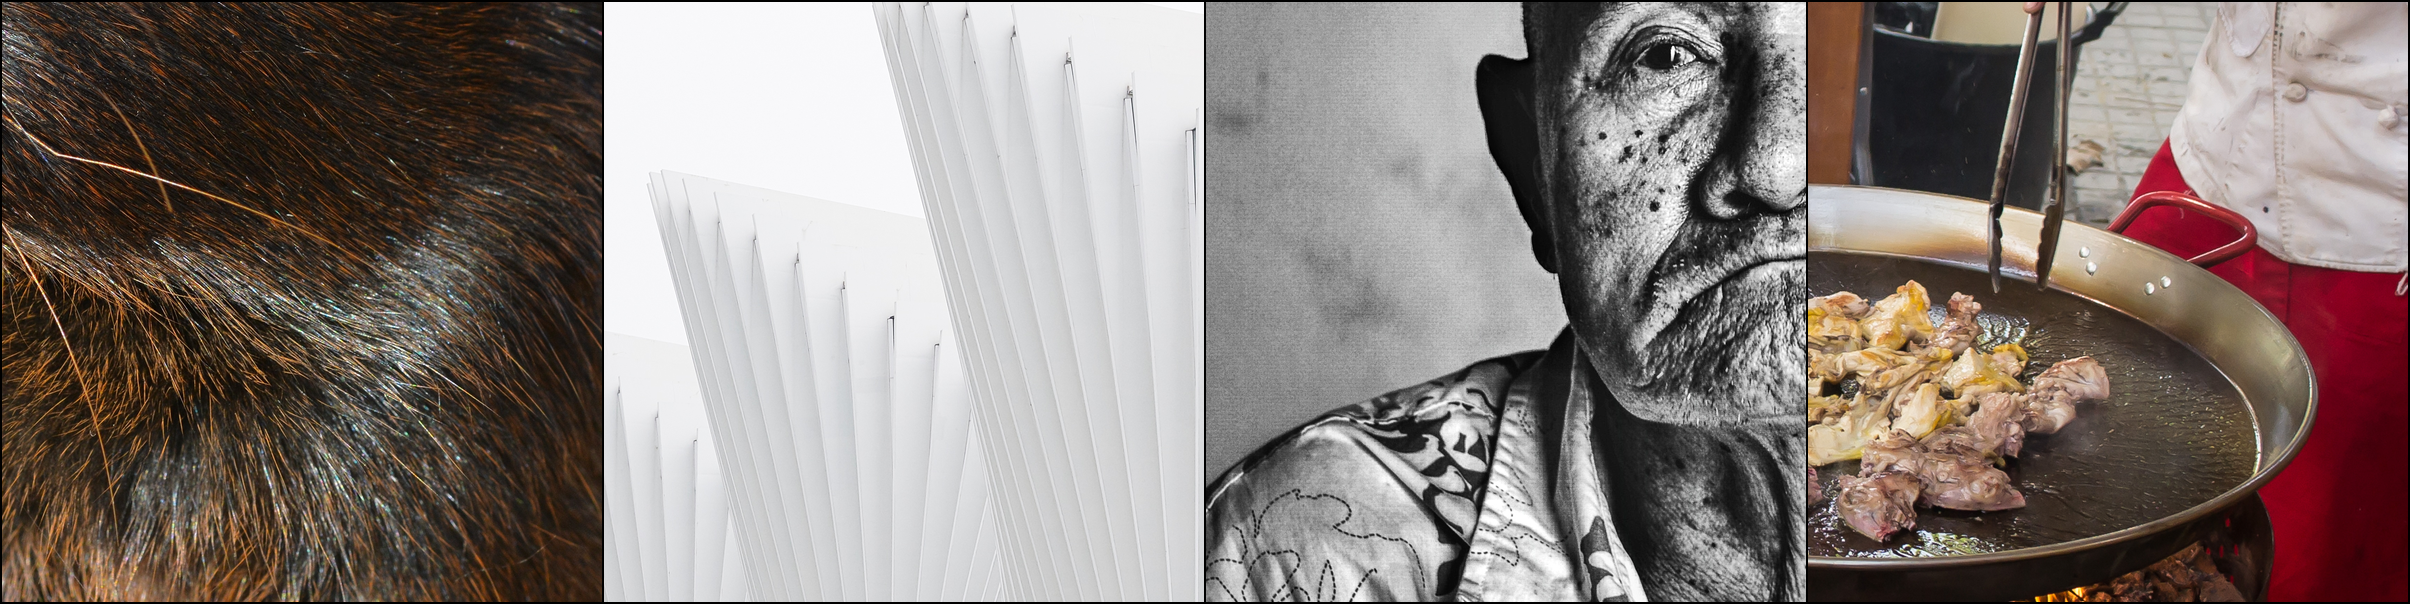

In [8]:
# High Res
transforms.ToPILImage()(torchvision.utils.make_grid(target))

In [16]:
img = Image.open('/home/hacker/Documents/Super-Resolution/datasets/DIV2K/custom/DIV2K_train_LR_600_150/0001.png')

In [ ]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in tqdm(range(num_epochs)):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()       # PyTorch accumulates the gradients on subsequent backward passes (useful for RNN)

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [ ]:
model = 
model = train_model(model, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=25)